In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import keras
import keras.optimizers as optimizers
from keras import layers, callbacks
from keras import regularizers
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
import pyreadr
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from scipy.stats import norm
import random

In [415]:
class DataCreation():
    def __init__(self, sample_size, timestamps):
        self.sample_size = sample_size
        self.timestamps = timestamps
        
    def create_intervals(self, seed):        
        random.seed(seed+100)
        intervals = []
        i = 0
        while i <= self.timestamps:
            length = random.randint(200, 1000)
            if (i + length + 400) > self.timestamps:
                sublist = list((i, self.timestamps))
                intervals.append(sublist)
                break
            else:
                sublist = list((i, i+length-1))
            intervals.append(sublist)
            i = i + length
        return intervals
    
    def create_df(self, seed):
        self.f_x = np.array([])
        
        partitions_1 = self.create_intervals(seed)
        partitions_2 = self.create_intervals(seed+1)
        random.seed(seed)
        for i in range(len(partitions_1)):
            freq = random.choice([2*i for i in range(1, 20)])
            co_ef = random.uniform(0, 10)
            self.f_x = np.append(self.f_x, co_ef * np.sin(np.linspace(0, freq * np.pi, partitions_1[i][1] - partitions_1[i][0] + 1)))

        for i in range(len(partitions_2)):
            mean = 0
            variance = random.uniform(0.1, 1)
            self.f_x[partitions_2[i][0]:partitions_2[i][1]] = self.f_x[partitions_2[i][0]:partitions_2[i][1]] + np.random.normal(mean, variance, partitions_2[i][1] - partitions_2[i][0])
        
        self.f_x = self.f_x[:self.timestamps]
        return self.f_x
    
    def train_test_split(self, split):
        g_x = self.f_x.reshape(self.timestamps // self.sample_size, self.sample_size)
        split = round(len(g_x) * split)
        self.train_X = g_x[:split]
        self.test_X = g_x[split:]
        
    def plot_df(self, sample, size):
        plt.figure(figsize=(12, 6))
        plt.plot(self.f_x)
        plt.xlim([sample*size, sample*size + size])

In [474]:
# Autoencoder
early_stopping = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.5, patience=50, restore_best_weights=True)

model = keras.Sequential([
    layers.Dense(256, input_shape=(sample_size,), activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(sample_size)
])
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="mse", metrics=['accuracy'])
history = model.fit(train_X, train_X, epochs=200, batch_size=128, validation_split=0.2, callbacks=[early_stopping], verbose=0)

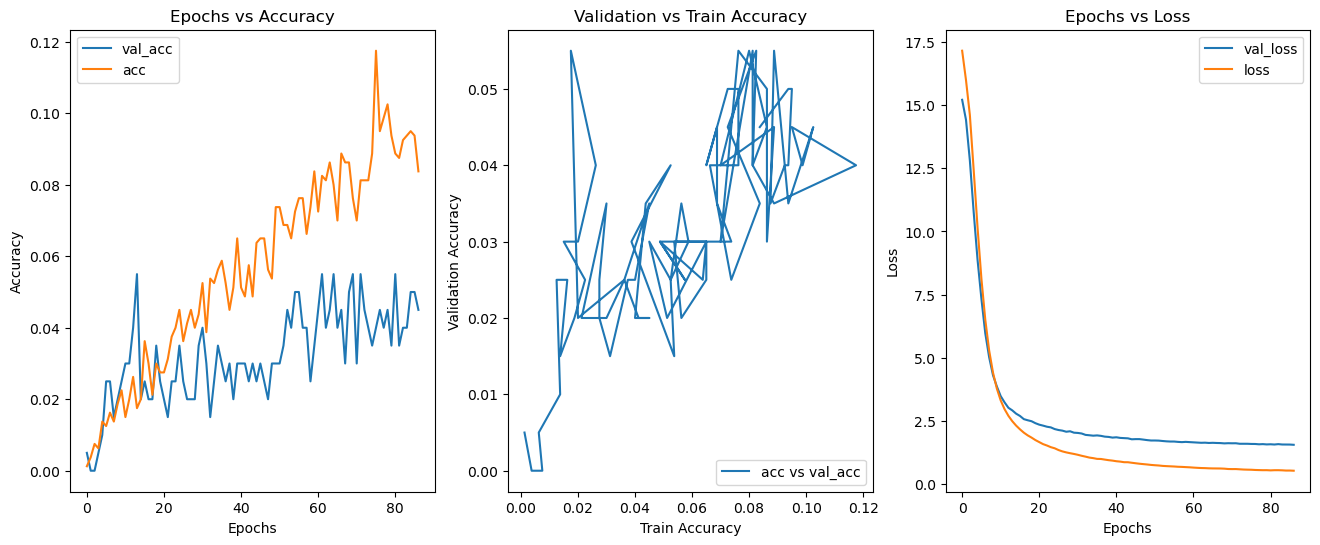

In [475]:
plt.figure(figsize=(16, 6))
h = history.history
plt.subplot(131)
plt.plot(range(len(h['val_accuracy'])), h['val_accuracy'], label='val_acc')
plt.plot(range(len(h['accuracy'])), h['accuracy'], label='acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title(f"Epochs vs Accuracy")

plt.subplot(132)
plt.plot(h['accuracy'], h['val_accuracy'], label='acc vs val_acc')
plt.xlabel("Train Accuracy")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.title(f"Validation vs Train Accuracy")
        
plt.subplot(133)
plt.plot(range(len(h['val_loss'])), h['val_loss'], label='val_loss')
plt.plot(range(len(h['loss'])), h['loss'], label='loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title(f"Epochs vs Loss")
plt.show()

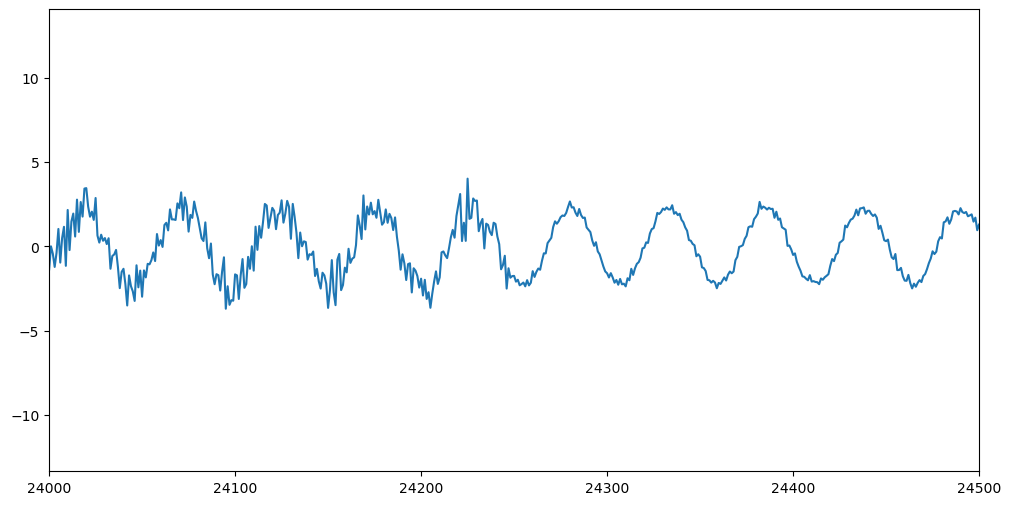

In [418]:
data = DataCreation(500, 500000)
f_x = data.create_df(200)
data.train_test_split(0.8)
train_X = data.train_X
test_X = data.test_X
data.plot_df(48, data.sample_size)

32/32 [==============================] - 0s 1ms/step


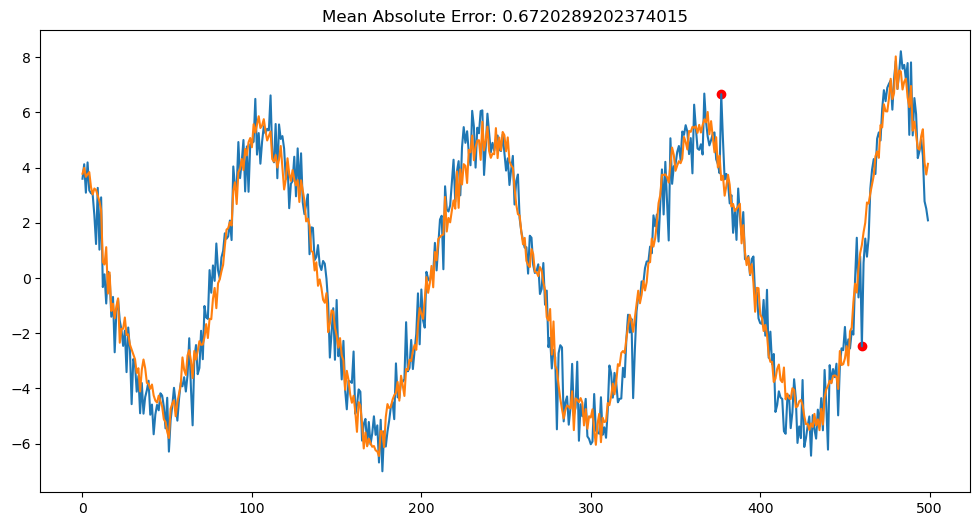

In [494]:
train_X_rec = model.predict(train_X)
sample = 4
threshold = 3
anomalies = np.where(np.abs(train_X[sample] - train_X_rec[sample]) > threshold)
plt.figure(figsize=(12, 6))
plt.title(f"Mean Absolute Error: {mae(train_X[sample], train_X_rec[sample])}")
plt.plot(train_X[sample])
plt.plot(train_X_rec[sample])
plt.scatter(anomalies, train_X[sample][anomalies], color='red')
plt.show()

In [300]:
sample = 3
threshold = 2
anomalies = np.where(np.abs(train_X[sample] - train_X_rec[sample]) > threshold)

array([ 30, 326, 357, 450, 465, 472, 484, 496], dtype=int64)

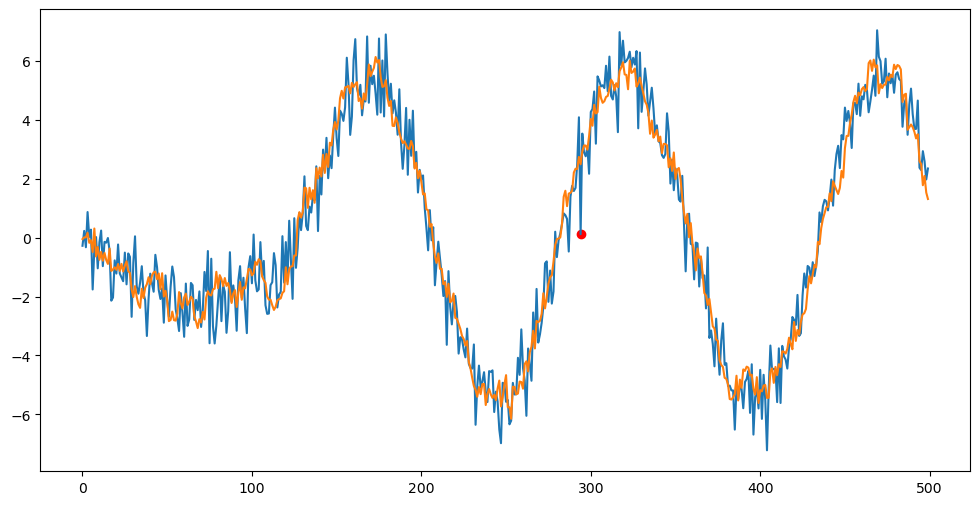

1

In [305]:
sample = 140
threshold = 2
anomalies = np.where(np.abs(train_X[sample] - train_X_rec[sample]) > threshold)
plt.figure(figsize=(12, 6))
plt.plot(train_X[sample])
plt.plot(train_X_rec[sample])
plt.scatter(anomalies, train_X[sample][anomalies], color='red')
plt.show()
len(train_X[2][anomalies])

In [484]:
sample_error = np.array([])
for i in range(len(train_X)):
    sample_error = np.append(sample_error, mae(train_X[i], train_X_rec[i]))
print(sample_error.max())
print(np.where(sample_error == sample_error.max()))
temp_df = pd.DataFrame({'values': sample_error})
#temp_df.describe()
len(np.where(sample_error > 1)[0])

3.7683009279498054
(array([938], dtype=int64),)


120

7/7 [==============================] - 0s 2ms/step


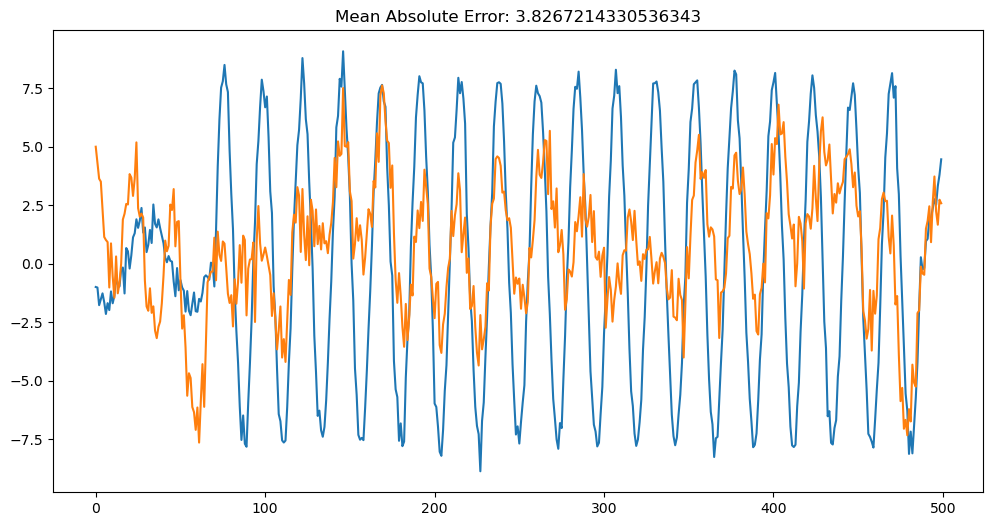

In [273]:
test_X_rec = model.predict(test_X)
sample = 140
plt.figure(figsize=(12, 6))
plt.title(f"Mean Absolute Error: {mae(test_X[sample], test_X_rec[sample])}")
plt.plot(test_X[sample])
plt.plot(test_X_rec[sample])
plt.show()

In [272]:
sample_error = np.array([])
for i in range(len(test_X)):
    sample_error = np.append(sample_error, mae(test_X[i], test_X_rec[i]))
print(sample_error.max())
np.where(sample_error == sample_error.max())

3.8267214330536343


(array([140], dtype=int64),)

Two methods to anomaly detection: 
<br>1. Using autoencoders, then finding threshold value using f1 score
<br>2. Moving average, calculate the standard deviation, and see if a point deviates away from 3 standard deviations

### Moving Average

In [542]:
data = DataCreation(500, 500000)
f_x = data.create_df(100)
data.train_test_split(0.8)
train_X = data.train_X
test_X = data.test_X

#### Implement faulty data

In [ ]:
test_X_temp = test_X.reshape(test_X.shape[0] * test_X.shape[1])
random.seed(900)
num_anomalies = random.randint(100, 200)
for i in range(num_anomalies):
    

In [546]:
window_size=50
moving_average = np.zeros(window_size // 2).tolist()
standard_dev = np.zeros(window_size // 2).tolist()
for i in range(timestamps-window_size):
    window = f_x[i:i+window_size]
    window_average = sum(window) / window_size
    standard_dev.append(np.std(np.array(window)))
    moving_average.append(window_average)
np.array(standard_dev)

array([0.        , 0.        , 0.        , ..., 3.72782017, 3.66923937,
       3.64515101])

In [547]:
anomalies = []
for i in range(window_size//2, timestamps-window_size):
    threshold_1 = moving_average[i] + 2.9 * standard_dev[i]
    threshold_2 = moving_average[i] - 2.9 * standard_dev[i]
    if f_x[i] > threshold_1 or f_x[i] < threshold_2:
        anomalies.append(i)
np.array(anomalies)

array([  2244,   3055,   5221,  25395,  26145,  26375,  26490,  26691,
        26731,  29009,  31558,  33626,  40840,  41204,  41562,  41622,
        41880,  42375,  43928,  44153,  44190,  47294,  47310,  56181,
        65758,  67146,  67248,  67610,  74080,  74434,  74602,  74688,
        74787,  78350,  78528,  78707,  82399,  82464,  82583,  83194,
        83258,  87291,  91591,  91724,  91952,  92000,  98157,  98193,
        99589,  99684, 105016, 105745, 109578, 114602, 114669, 114758,
       114855, 117240, 120433, 129389, 129728, 139262, 140421, 140461,
       140580, 159075, 161275, 170449, 170930, 175298, 175533, 175868,
       175908, 177066, 180966, 181309, 182018, 184968, 185074, 185108,
       185824, 207820, 207901, 208661, 211386, 212890, 213274, 214272,
       214665, 218724, 218826, 219059, 222445, 228879, 229119, 238810,
       239039, 239500, 243619, 246016, 250144, 251823, 253530, 259768,
       262176, 268317, 269939, 271263, 280199, 280451, 280927, 284314,
      

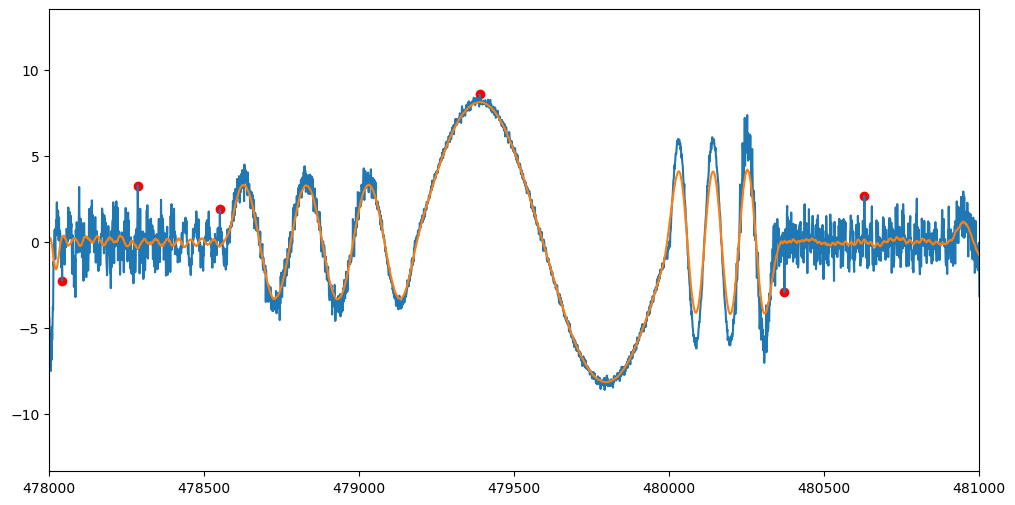

In [549]:
i = 478
plt.figure(figsize=(12, 6))
plt.plot(f_x)
plt.plot(moving_average)
plt.scatter(np.array(anomalies), f_x[anomalies], color='red')
plt.xlim([i*1000, i*1000 + 3000])
plt.show()

In [505]:
from statsmodels.tsa.arima.model import ARIMA
MA_model = ARIMA(f_x, order=(0, 0, 10))
results = MA_model.fit()
results.summary

C:\Users\HUAN20920\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<bound method SARIMAXResults.summary of <statsmodels.tsa.arima.model.ARIMAResults object at 0x0000013744C76210>>

In [506]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:               500000
Model:                ARIMA(0, 0, 10)   Log Likelihood             -694799.179
Date:                Tue, 12 Dec 2023   AIC                        1389622.358
Time:                        17:05:04   BIC                        1389755.827
Sample:                             0   HQIC                       1389660.142
                             - 500000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.013      0.071      0.943      -0.024       0.026
ma.L1          0.8147      0.001    712.804      0.000       0.812       0.817
ma.L2          0.9932      0.001    705.384      0.000       0.990       0.996
ma.L3          1.1134      0.002    661.310      0.000       1.110       1.117
ma.L4          1.1548      0.002    603.124      0.000       1.151       1.159
ma.L5          1.1135      0.002    544.980      0.000       1.109       1.117
ma.L6          0.9950      0.002    483.869      0.000       0.991       0.999
ma.L7          0.8196      0.002    423.218      0.000       0.816       0.823
ma.L8          0.6149      0.002    358.025      0.000       0.611       0.618
ma.L9          0.4101      0.001    284.523      0.000       0.407       0.413
ma.L10         0.2269      0.001    195.209      0.000       0.225       0.229
sigma2         0.9430      0.002    608.185      0.000       0.940       0.946
===================================================================================
Ljung-Box (L1) (Q):                1135.32   Jarque-Bera (JB):             23394.22
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [527]:
ma_predictions = results.predict(0, 500000)

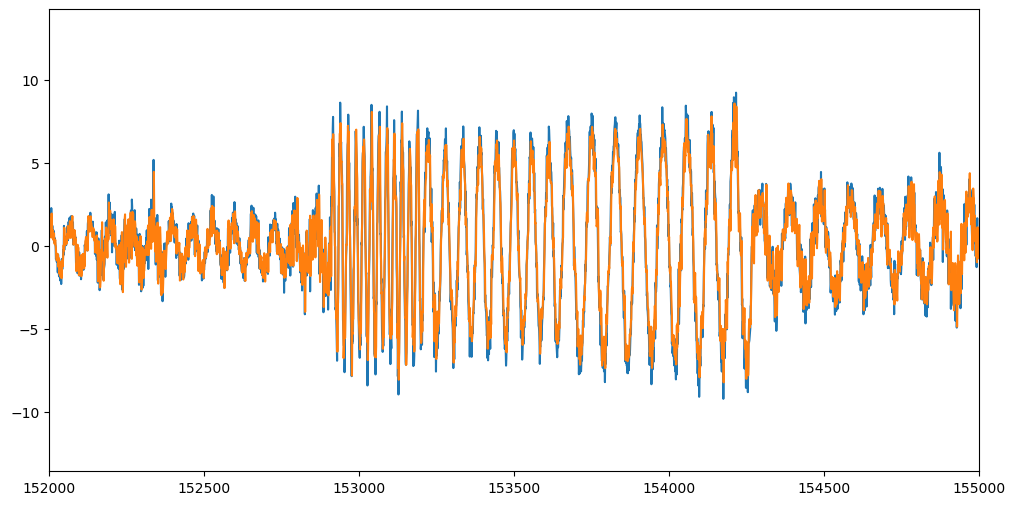

In [533]:
i = 152
plt.figure(figsize=(12, 6))
plt.plot(f_x)
plt.plot(ma_predictions)
# plt.scatter(np.array(anomalies), f_x[anomalies], color='red')
plt.xlim([i*1000, i*1000 + 3000])
plt.show()